# Filtrage collaboratif avec Implicit
On va utiliser la version qui travaille avec le GPU

In [1]:
! nvidia-smi

Thu Apr 24 06:53:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   36C    P8              5W /   80W |      94MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Données

### Chargement du dataframe global

In [2]:
import pandas as pd

df = pd.read_parquet("./data/df_final.parquet")
print("✅ Dataset rechargé avec succès.")

✅ Dataset rechargé avec succès.


In [3]:
df.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,...,31,32,33,34,35,36,37,38,39,40
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,...,-0.321484,0.910162,-0.413011,0.680835,-0.418409,-0.526443,0.305625,-0.307805,-0.606366,-0.650556
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,...,-1.001013,0.797471,-0.492230,-0.305857,-1.307835,0.354010,0.696917,-0.486316,0.017210,-1.563045
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,...,-0.269690,0.873445,0.194144,0.056367,-0.431036,-0.020383,-0.376942,0.814494,0.709722,-1.030146
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,...,0.144034,-2.457183,-1.500929,-1.807169,-0.208940,-0.671638,-0.407914,2.561696,-1.379031,-1.877568
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,...,-1.163678,-0.230112,-2.132536,-0.729996,0.581913,-0.559910,-0.354824,-0.914158,-0.064399,-0.354175


### Liste des articles

In [4]:
df_articles = pd.read_csv("./data/articles_with_popularity.csv", encoding='utf-8')
df_articles

,article_id,category_id,created_at_ts,publisher_id,words_count,cluster,publish_time_dt,nb_clics,popularite_tag,popularity_norm
0,0,0,1513144419000,0,168,16,2017-12-13 05:53:39,0,jamais_cliqué,0.000000
1,1,1,1405341936000,0,189,11,2014-07-14 12:45:36,0,jamais_cliqué,0.000000
2,2,1,1408667706000,0,250,3,2014-08-22 00:35:06,0,jamais_cliqué,0.000000
3,3,1,1408468313000,0,230,3,2014-08-19 17:11:53,1,banal,0.000027
4,4,1,1407071171000,0,162,3,2014-08-03 13:06:11,0,jamais_cliqué,0.000000
...,...,...,...,...,...,...,...,...,...,...
364042,364042,460,1434034118000,0,144,2,2015-06-11 14:48:38,0,jamais_cliqué,0.000000
364043,364043,460,1434148472000,0,463,7,2015-06-12 22:34:32,8,banal,0.000215
364044,364044,460,1457974279000,0,177,6,2016-03-14 16:51:19,0,jamais_cliqué,0.000000
364045,364045,460,1515964737000,0,126,1,2018-01-14 21:18:57,0,jamais_cliqué,0.000000


### Chargement des embeddings réduits

In [5]:
import pandas as pd

embeddings_df = pd.read_parquet('./data/articles_embeddings_pca.parquet')
print(embeddings_df.shape)

(364047, 41)


In [6]:
embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
article_id,,,,,,,,,,,,,,,,,,,,,
0,-1.854453,-5.592402,1.708724,-3.835164,1.415795,0.252210,0.426074,0.545480,-0.807394,1.520171,...,0.387738,-0.088799,0.990514,1.060148,-0.218378,-1.099852,-1.175524,1.370632,-0.264816,0.010117
1,-5.361997,4.122991,-2.357516,-3.428017,-0.431079,3.722260,2.389835,-1.267244,1.944162,2.980629,...,0.025565,-0.721510,0.649929,-0.405225,-0.090690,-3.094968,0.075186,0.245235,-1.250343,0.294538
2,-3.600085,-0.132112,-6.027451,0.985617,0.211965,4.591712,-1.815688,-2.170389,-2.783090,2.804910,...,0.565647,-1.862223,-0.336458,0.072410,0.241466,-0.877634,0.154883,1.133963,0.946740,-1.811314
3,-1.158963,7.293352,-5.916713,-1.370524,2.172241,-1.682487,1.070822,-2.160001,1.947324,4.069597,...,0.074049,-0.612824,-1.511408,1.071736,1.991838,-2.076190,-1.690459,-1.122692,0.714619,-1.576244
4,-1.142884,2.569328,-2.891860,-0.273997,2.913007,5.608970,0.308953,0.310888,-1.054171,2.158180,...,-1.527867,-0.155615,-0.163345,0.037253,1.173636,-4.232923,-1.287476,1.053438,-0.486085,-0.144550


In [7]:
# conversion des embeddings en tableau NumPy (évite de calculer la matrice de similarité complète)
import numpy as np
article_ids = embeddings_df.index.to_numpy()
article_embeddings = embeddings_df.to_numpy()

# dictionnaire article_id -> vecteur
embedding_dict = dict(zip(article_ids, article_embeddings))

## Préparation des données pour Implicit

### Création de la matrice item-user
On a simplement ignoré les articles non cliqués.

In [8]:
from scipy.sparse import coo_matrix
from tqdm import tqdm
import numpy as np

def build_item_user_matrix(df_clicks):
    """
    Construit une matrice sparse (CSR) article × utilisateur pour implicit ALS,
    avec pondération linéaire des clics, remapping auto et barre de progression.

    Retourne :
    - item_user_matrix : matrice CSR [n_items_cliqués x n_users_actifs]
    - user_mapping : dict user_id → user_idx
    - item_mapping : dict click_article_id → item_idx
    """

    # Agrégation des clics
    df_user_item = (
        df_clicks.groupby(['user_id', 'click_article_id'])
        .size()
        .reset_index(name='click_strength')
    )

    # Vérification remapping
    u_ids = df_user_item['user_id'].values
    need_remap_users = not (
        u_ids.dtype.kind in 'iu' and u_ids.min() == 0 and len(np.unique(u_ids)) == u_ids.max() + 1
    )

    i_ids = df_user_item['click_article_id'].values
    need_remap_items = not (
        i_ids.dtype.kind in 'iu' and i_ids.min() == 0 and len(np.unique(i_ids)) == i_ids.max() + 1
    )

    if not need_remap_users and not need_remap_items:
        print("✅ Remapping non nécessaire : user_id et click_article_id déjà indexés proprement.")
    else:
        print("🔁 Remapping nécessaire : conversion des IDs en indices entiers contigus.")

    # Création des mappings avec tqdm
    print("🔄 Construction des dictionnaires d’indexation...")
    user_ids = df_user_item['user_id'].unique()
    item_ids = df_user_item['click_article_id'].unique()

    user_mapping = {uid: idx for idx, uid in enumerate(tqdm(user_ids, desc="🔢 Mapping users"))}
    item_mapping = {iid: idx for idx, iid in enumerate(tqdm(item_ids, desc="🧾 Mapping articles"))}

    df_user_item['user_idx'] = df_user_item['user_id'].map(user_mapping)
    df_user_item['item_idx'] = df_user_item['click_article_id'].map(item_mapping)

    print("📐 Construction de la matrice sparse...")
    item_user_matrix = coo_matrix(
        (df_user_item['click_strength'],
         (df_user_item['item_idx'], df_user_item['user_idx']))
    ).tocsr()
    item_user_matrix *= 40  # confiance implicite standard

    print("✅ Matrice prête :", item_user_matrix.shape)
    return item_user_matrix, user_mapping, item_mapping


In [9]:
item_user_matrix, user_mapping, item_mapping = build_item_user_matrix(df)


🔁 Remapping nécessaire : conversion des IDs en indices entiers contigus.
🔄 Construction des dictionnaires d’indexation...


🧾 Mapping articles: 100%|██████████| 46033/46033 [00:00<00:00, 3865393.31it/s]


📐 Construction de la matrice sparse...
✅ Matrice prête : (46033, 322897)


### Visualisation de la matrice item-user

In [10]:
import matplotlib.pyplot as plt

def plot_sparse_matrix_density(sparse_matrix, title="Matrice sparse (articles × utilisateurs)"):
    plt.figure(figsize=(10, 6))
    plt.spy(sparse_matrix, markersize=0.5)
    plt.title(title)
    plt.xlabel("Utilisateurs")
    plt.ylabel("Articles")
    plt.grid(True)
    plt.show()


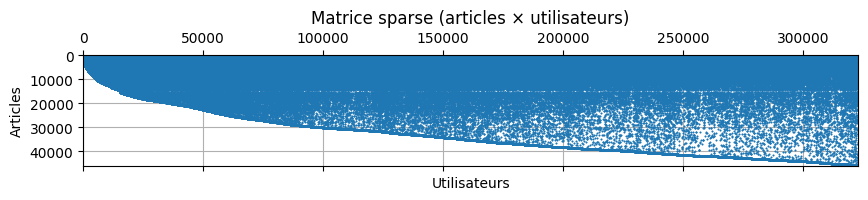

In [11]:
plot_sparse_matrix_density(item_user_matrix)

<div style="padding: 10px; border-radius: 5px; background-color: #e7f3fe; color: #31708f; border-left: 6px solid #2196F3;">
ℹ️ <strong>Explication :</strong> La répartition des données dans la matrice reflète le fait que l'on a enregistré les clics selon le temps, les utilisateurs et les articles s'accumulent petit à petit (pas de shuffle lors du mappage des index)
</div>

In [12]:
def print_matrix_density(sparse_matrix):
    n_total = sparse_matrix.shape[0] * sparse_matrix.shape[1]
    n_nonzero = sparse_matrix.nnz
    density = n_nonzero / n_total * 100

    print(f"📦 Taux de remplissage : {n_nonzero:,} éléments non nuls")
    print(f"📐 Dimensions         : {sparse_matrix.shape}")
    print(f"📊 Densité            : {density:.6f}%")

In [13]:
print_matrix_density(item_user_matrix)

📦 Taux de remplissage : 2,950,710 éléments non nuls
📐 Dimensions         : (46033, 322897)
📊 Densité            : 0.019851%


## Mise en oeuvre du modèle ALS (Alternative Least Squares)

In [14]:
import time
from implicit.gpu.als import AlternatingLeastSquares

# Paramètres
factors = 64
iterations = 15
regularization = 0.1

# Modèle ALS GPU
model = AlternatingLeastSquares(
    factors=factors,
    regularization=regularization,
    iterations=iterations
)

# Entraînement
print("⏱️ Entraînement ALS en cours...")
start = time.time()
model.fit(item_user_matrix)
end = time.time()
print(f"✅ Modèle entraîné en {end - start:.2f} secondes")


⏱️ Entraînement ALS en cours...


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 15/15 [00:01<00:00, 11.44it/s]

✅ Modèle entraîné en 1.59 secondes


### 🔁 Étape 1 : Split Leave-One-Out

In [15]:
def leave_one_out_split(item_user_matrix):
    """
    Effectue un split leave-one-out par utilisateur sur une matrice implicite.
    Retourne :
    - train_matrix (item × user, CSR)
    - test_data : liste de (user_idx, item_idx) à prédire
    """

    user_item_matrix = item_user_matrix.T.tocsr()
    train_matrix = user_item_matrix.copy().tolil()
    test_data = []

    print("🔄 Création du split leave-one-out...")
    for user_idx in range(user_item_matrix.shape[0]):
        start_ptr = user_item_matrix.indptr[user_idx]
        end_ptr = user_item_matrix.indptr[user_idx + 1]
        user_items = user_item_matrix.indices[start_ptr:end_ptr]

        if len(user_items) < 1:
            continue

        test_item = np.random.choice(user_items)
        test_data.append((user_idx, test_item))

        train_matrix[user_idx, test_item] = 0

    train_matrix = train_matrix.tocsr().T  # Rebasculer au format item × user
    print(f"✅ Split terminé : {len(test_data)} interactions mises de côté pour test.")
    return train_matrix, test_data


✅ Il faut garder uniquement les utilisateurs ≥ 2 clics:  filtrage des utilisateurs ayant seulement 1 clic (ceux que implicit ne peut pas entraîner).

In [16]:
# Création d'une version filtrée de la matrice
min# Création d'une version filtrée de la matrice
min_interactions = 2
user_activity = (item_user_matrix.T > 0).sum(axis=1).A1
total_users = user_activity.shape[0]
active_users = np.where(user_activity >= min_interactions)[0]
n_active = len(active_users)
n_filtered = total_users - n_active

# Filtrer la matrice
filtered_user_item_matrix = item_user_matrix[:, active_users]

# Log informatif
print(f"✅ Filtrage utilisateurs terminé")
print(f"   - Total utilisateurs initiaux  : {total_users}")
print(f"   - Conservés (≥ {min_interactions} clics) : {n_active}")
print(f"   - Supprimés (inactifs)         : {n_filtered}")


✅ Filtrage utilisateurs terminé
   - Total utilisateurs initiaux  : 322897
   - Conservés (≥ 2 clics) : 322897
   - Supprimés (inactifs)         : 0


In [17]:
train_matrix, test_data = leave_one_out_split(filtered_user_item_matrix)

🔄 Création du split leave-one-out...
✅ Split terminé : 322897 interactions mises de côté pour test.


In [18]:
# On s'assure que les indices dans test_data existent dans les facteurs appris
test_data = [
    (u, i) for u, i in test_data
    if u < train_matrix.T.shape[0] and i < train_matrix.shape[0]
]
print(f"✅ Test data filtrée : {len(test_data)} interactions conservées")

✅ Test data filtrée : 322897 interactions conservées


### ⚙️ 2. Test de plusieurs algorithmes
🧠 Contruit une fonction générique :
✅ train_and_predict(model_class, params, train_matrix, test_data, N=5)

Elle doit :<br>
- Entraîner le modèle sur train_matrix
- Générer les N recommandations par utilisateur
- Comparer à test_data pour calculer les prédictions top-N
- Retourner un dictionnaire user_idx → [item_idx_1, item_idx_2, ..., item_idx_N]

In [19]:
def train_and_predict(model_class, params, train_matrix, test_data, N=5):
    """
    Entraîne un modèle `implicit` sur train_matrix, puis génère les top-N prédictions
    pour les utilisateurs présents dans test_data.
    
    Arguments :
    - model_class : ex. `implicit.gpu.als.AlternatingLeastSquares`
    - params : dict d’hyperparamètres à passer au modèle
    - train_matrix : matrice CSR (item × user)
    - test_data : liste (user_idx, item_idx)
    - N : top-N à prédire
    
    Retourne :
    - recommendations : dict {user_idx: [item_idx1, item_idx2, ..., item_idxN]}
    """
    from tqdm import tqdm

    print(f"⚙️ Entraînement du modèle {model_class.__name__}...")
    model = model_class(**params)
    model.fit(train_matrix)

    user_item_matrix = train_matrix.T.tocsr()  # user × item
    recommendations = {}

    skipped = 0
    print("🔮 Génération des recommandations top-N...")
    for user_idx, _ in tqdm(test_data, desc="📡 Prédiction"):
        if user_idx >= model.user_factors.shape[0]:
            skipped += 1
            continue  # utilisateur absent du modèle
    
        user_interactions = user_item_matrix[user_idx]
        item_indices, _ = model.recommend(user_idx, user_interactions, N=N, filter_already_liked_items=True)
        recommendations[user_idx] = item_indices
        if skipped := 0:
            print(f"⚠️ {skipped} utilisateurs ignorés (absents du modèle)")

    return recommendations


In [20]:
from implicit.gpu.als import AlternatingLeastSquares

params = {
    "factors": 64,
    "regularization": 0.1,
    "iterations": 15
}

reco_top5 = train_and_predict(
    model_class=AlternatingLeastSquares,
    params=params,
    train_matrix=train_matrix,
    test_data=test_data,
    N=5
)


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.015757322311401367 seconds
  warnings.warn(


⚙️ Entraînement du modèle AlternatingLeastSquares...


100%|██████████| 15/15 [00:01<00:00, 13.85it/s]


🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 322897/322897 [00:31<00:00, 10355.75it/s] 


### 📏 Étape 3 : Calcul des métriques Top-N

In [21]:
import numpy as np

def evaluate_topn_metrics(recommendations, test_data, N=5):
    """
    Évalue les performances top-N d’un système de recommandation.
    
    Arguments :
    - recommendations : dict {user_idx: [item_idx1, item_idx2, ..., item_idxN]}
    - test_data : list of (user_idx, item_idx) ground truth
    - N : top-N à évaluer
    
    Retourne :
    - dict de métriques moyennes : hit, precision, map, ndcg
    """
    hits, precisions, ndcgs, maps = [], [], [], []

    for user_idx, true_item in test_data:
        preds = recommendations.get(user_idx)
        if preds is None:
            continue
    
        preds = list(preds)  # 💡 convert to list to use .index()
        
        if true_item in preds:
            rank = preds.index(true_item)
            hits.append(1)
            precisions.append(1 / (rank + 1))
            maps.append(1 / (rank + 1))
            ndcgs.append(1 / np.log2(rank + 2))
        else:
            hits.append(0)
            precisions.append(0)
            maps.append(0)
            ndcgs.append(0)

    metrics = {
        f"Hit@{N}": np.mean(hits),
        f"Precision@{N}": np.mean(precisions),
        f"MAP@{N}": np.mean(maps),
        f"NDCG@{N}": np.mean(ndcgs),
        "users_evaluated": len(hits)
    }
    return metrics

In [22]:
metrics = evaluate_topn_metrics(reco_top5, test_data, N=5)

for k, v in metrics.items():
    print(f"{k:<15}: {v:.4f}" if isinstance(v, float) else f"{k:<15}: {v}")

Hit@5          : 0.0004
Precision@5    : 0.0002
MAP@5          : 0.0002
NDCG@5         : 0.0002
users_evaluated: 46033


### 📐 Étape 4 : Calcul de MAE et RMSE à partir du modèle implicit

🔥 Sur GPU les objets model.user_factors[...] et model.item_factors[...] ne sont pas des numpy.array classiques, mais des objets implicit.gpu._cuda.Matrix.<br>
🧠 Problème : L’opérateur @ (produit scalaire) ne fonctionne pas directement sur ces objets GPU, on les passe en numpy + applatissement

In [23]:
    # Inversement de la matrice
    user_item_matrix = train_matrix.T.tocsr()

In [24]:
def evaluate_prediction_error(model, test_data, user_item_matrix):
    """
    Calcule MAE et RMSE pour les paires (user, item) du test.
    
    Arguments :
    - model : modèle entraîné (ex. ALS)
    - test_data : liste (user_idx, item_idx)
    - user_item_matrix : matrice CSR (user × item), pour recalcul_user
    
    Retourne :
    - dict avec MAE et RMSE
    """
    
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    import numpy as np

    y_true = []
    y_pred = []

    for user_idx, item_idx in test_data:
        if user_idx >= model.user_factors.shape[0]:
            continue  # utilisateur absent
    
        u = model.user_factors[user_idx].to_numpy().ravel()
        i = model.item_factors[item_idx].to_numpy().ravel()
        score = u @ i
    
        y_true.append(1.0)  # clic observé
        y_pred.append(score)

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred) # 🧨 sklearn 1.6.2 pas de squared=False
    rmse = np.sqrt(mse) # sqrt manuel


    return {
        "MAE": mae,
        "RMSE": rmse,
        "users_evaluated": len(y_true)
    }

In [25]:
error_metrics = evaluate_prediction_error(model, test_data, user_item_matrix)

for k, v in error_metrics.items():
    print(f"{k:<15}: {v:.4f}" if isinstance(v, float) else f"{k:<15}: {v}")


MAE            : 0.9935
RMSE           : 0.9950
users_evaluated: 46033


### 📊 5. Évaluation complète

In [26]:
def to_numpy_array(x):
    return x.to_numpy().ravel() if hasattr(x, "to_numpy") else np.asarray(x).ravel()

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from tqdm import tqdm

def to_numpy_array(x):
    return x.to_numpy().ravel() if hasattr(x, "to_numpy") else np.asarray(x).ravel()

def evaluate_model_all_metrics(model_class, params, train_matrix, test_data, N=5):
    """
    Évalue un modèle implicit complet : top-N + erreur de prédiction (RMSE/MAE si applicable).
    """

    print(f"⚙️ Entraînement de {model_class.__name__} avec N={N}...")

    # Détection des modèles à exclusion de score brut (pas de facteurs utilisateurs/items)
    raw_score_supported = hasattr(model_class, "user_factors") or model_class.__name__ in [
        "AlternatingLeastSquares",
        "BayesianPersonalizedRanking",
        "LogisticMatrixFactorization"
    ]

    if model_class.__name__ == "ItemItemRecommender":
        train_matrix = train_matrix.astype(np.float64)

    model = model_class(**params)
    model.fit(train_matrix)

    user_item_matrix = train_matrix.T.tocsr()
    y_true, y_pred = [], []
    hits, precisions, maps, ndcgs = [], [], [], []
    skipped = 0

    for user_idx, true_item in tqdm(test_data, desc="📡 Évaluation"):
        try:
            user_interactions = user_item_matrix[user_idx]
            item_indices, scores = model.recommend(user_idx, user_interactions, N=N, filter_already_liked_items=True)
            preds = list(item_indices)

            if true_item in preds:
                rank = preds.index(true_item)
                hits.append(1)
                precisions.append(1 / (rank + 1))
                maps.append(1 / (rank + 1))
                ndcgs.append(1 / np.log2(rank + 2))
            else:
                hits.append(0)
                precisions.append(0)
                maps.append(0)
                ndcgs.append(0)

            if raw_score_supported:
                u = to_numpy_array(model.user_factors[user_idx])
                i = to_numpy_array(model.item_factors[true_item])
                score = u @ i
                y_true.append(1.0)
                y_pred.append(score)

        except Exception:
            skipped += 1

    metrics = {
        "Model": model_class.__name__,
        f"Hit@{N}": np.mean(hits),
        f"Precision@{N}": np.mean(precisions),
        f"MAP@{N}": np.mean(maps),
        f"NDCG@{N}": np.mean(ndcgs),
        "MAE": np.nan,
        "RMSE": np.nan,
        "Users évalués": len(hits),
        "Skippés": skipped
    }

    if raw_score_supported and y_true:
        metrics["MAE"] = mean_absolute_error(y_true, y_pred)
        metrics["RMSE"] = np.sqrt(mean_squared_error(y_true, y_pred))

    return metrics


In [28]:
from implicit.gpu.als import AlternatingLeastSquares

als_params = {
    "factors": 64,
    "regularization": 0.1,
    "iterations": 15
}

results_als = evaluate_model_all_metrics(
    model_class=AlternatingLeastSquares,
    params=als_params,
    train_matrix=train_matrix,
    test_data=test_data,
    N=5
)

for k, v in results_als.items():
    print(f"{k:<15}: {v:.4f}" if isinstance(v, float) else f"{k:<15}: {v}")


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.020143985748291016 seconds
  warnings.warn(


⚙️ Entraînement de AlternatingLeastSquares avec N=5...


📡 Évaluation: 100%|██████████| 322897/322897 [00:43<00:00, 7451.81it/s] 


Model          : AlternatingLeastSquares
Hit@5          : 0.0004
Precision@5    : 0.0001
MAP@5          : 0.0001
NDCG@5         : 0.0002
MAE            : 0.9935
RMSE           : 0.9950
Users évalués  : 46033
Skippés        : 276864


### 🎨 6. Visualisation complète avec plusieurs modèles

In [29]:
def grid_search_models(models_with_grids, train_matrix, test_data, N=5):
    """
    Teste plusieurs modèles implicit avec des grilles d'hyperparamètres.
    
    Arguments :
    - models_with_grids : dict {model_class: list[params_dict]}
    - train_matrix : matrice CSR (item × user)
    - test_data : liste (user_idx, item_idx)
    - N : taille du top-N à évaluer

    Retourne :
    - DataFrame des résultats pour chaque combinaison (modèle + params)
    """
    results = []

    for model_class, grid in models_with_grids.items():
        for param_set in grid:
            print(f"\n🔍 Test de {model_class.__name__} avec paramètres : {param_set}")
            metrics = evaluate_model_all_metrics(model_class, param_set, train_matrix, test_data, N=N)
            metrics.update({f"param_{k}": v for k, v in param_set.items()})
            results.append(metrics)

    return pd.DataFrame(results)


In [30]:
from implicit.gpu.als import AlternatingLeastSquares
from implicit.gpu.bpr import BayesianPersonalizedRanking
from implicit.cpu.lmf import LogisticMatrixFactorization
from implicit.nearest_neighbours import ItemItemRecommender

model_grids = {
    AlternatingLeastSquares: [
        {"factors": 32, "regularization": 0.1, "iterations": 10},
        {"factors": 64, "regularization": 0.05, "iterations": 15}
    ],
    BayesianPersonalizedRanking: [
        {"factors": 64, "regularization": 0.01, "iterations": 15},
        {"factors": 128, "regularization": 0.05, "iterations": 20}
    ],
    LogisticMatrixFactorization: [
        {"factors": 64, "regularization": 0.1, "iterations": 15},
        {"factors": 128, "regularization": 0.05, "iterations": 20}
    ],
    ItemItemRecommender: [
        {"K": 100},
        {"K": 200}
    ]
}

df_grid_results = grid_search_models(model_grids, train_matrix, test_data, N=5)


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.01903533935546875 seconds
  warnings.warn(



🔍 Test de AlternatingLeastSquares avec paramètres : {'factors': 32, 'regularization': 0.1, 'iterations': 10}
⚙️ Entraînement de AlternatingLeastSquares avec N=5...


📡 Évaluation: 100%|██████████| 322897/322897 [00:34<00:00, 9460.22it/s] 
/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.014917373657226562 seconds
  warnings.warn(



🔍 Test de AlternatingLeastSquares avec paramètres : {'factors': 64, 'regularization': 0.05, 'iterations': 15}
⚙️ Entraînement de AlternatingLeastSquares avec N=5...


📡 Évaluation: 100%|██████████| 322897/322897 [00:43<00:00, 7451.62it/s] 
/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.015022039413452148 seconds
  warnings.warn(



🔍 Test de BayesianPersonalizedRanking avec paramètres : {'factors': 64, 'regularization': 0.01, 'iterations': 15}
⚙️ Entraînement de BayesianPersonalizedRanking avec N=5...


📡 Évaluation: 100%|██████████| 322897/322897 [00:47<00:00, 6755.48it/s] 
/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.01460123062133789 seconds
  warnings.warn(



🔍 Test de BayesianPersonalizedRanking avec paramètres : {'factors': 128, 'regularization': 0.05, 'iterations': 20}
⚙️ Entraînement de BayesianPersonalizedRanking avec N=5...


📡 Évaluation: 100%|██████████| 322897/322897 [01:00<00:00, 5330.08it/s] 
/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.01788043975830078 seconds
  warnings.warn(



🔍 Test de LogisticMatrixFactorization avec paramètres : {'factors': 64, 'regularization': 0.1, 'iterations': 15}
⚙️ Entraînement de LogisticMatrixFactorization avec N=5...


📡 Évaluation: 100%|██████████| 322897/322897 [02:35<00:00, 2071.58it/s] 
/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.017832040786743164 seconds
  warnings.warn(



🔍 Test de LogisticMatrixFactorization avec paramètres : {'factors': 128, 'regularization': 0.05, 'iterations': 20}
⚙️ Entraînement de LogisticMatrixFactorization avec N=5...


📡 Évaluation: 100%|██████████| 322897/322897 [04:24<00:00, 1221.56it/s] 
/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.01865983009338379 seconds
  warnings.warn(



🔍 Test de ItemItemRecommender avec paramètres : {'K': 100}
⚙️ Entraînement de ItemItemRecommender avec N=5...


📡 Évaluation: 100%|██████████| 322897/322897 [00:14<00:00, 21630.73it/s]
/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.018275022506713867 seconds
  warnings.warn(



🔍 Test de ItemItemRecommender avec paramètres : {'K': 200}
⚙️ Entraînement de ItemItemRecommender avec N=5...


📡 Évaluation: 100%|██████████| 322897/322897 [00:17<00:00, 18137.49it/s]


In [31]:
df_grid_results

,Model,Hit@5,Precision@5,MAP@5,NDCG@5,MAE,RMSE,Users évalués,Skippés,param_factors,param_regularization,param_iterations,param_K
0,AlternatingLeastSquares,0.000434,0.000164,0.000164,0.000230,0.992360,0.993913,46033,276864,32.0,0.10,10.0,NaN
1,AlternatingLeastSquares,0.000413,0.000153,0.000153,0.000217,0.993691,0.995228,46033,276864,64.0,0.05,15.0,NaN
2,BayesianPersonalizedRanking,0.000043,0.000012,0.000012,0.000019,0.873328,0.936622,46033,276864,64.0,0.01,15.0,NaN
3,BayesianPersonalizedRanking,0.000022,0.000011,0.000011,0.000014,0.894063,0.965559,46033,276864,128.0,0.05,20.0,NaN
4,LogisticMatrixFactorization,0.000087,0.000040,0.000040,0.000051,7.156113,8.635946,46033,276864,64.0,0.10,15.0,NaN
5,LogisticMatrixFactorization,0.000239,0.000094,0.000094,0.000131,24.824385,28.619849,46033,276864,128.0,0.05,20.0,NaN
6,ItemItemRecommender,0.000108,0.000041,0.000041,0.000058,NaN,NaN,322897,0,NaN,NaN,NaN,100.0
7,ItemItemRecommender,0.000115,0.000042,0.000042,0.000060,NaN,NaN,322897,0,NaN,NaN,NaN,200.0


🧠 BayesianPersonalizedRanking testé (non listé) ne fonctionne pas<br>
BPR est conçu pour optimiser le rang relatif entre les items vu vs non vu.<br>
Or dans le dataset :<br>
    peu de clics par utilisateur (interactions faibles)<br>
    énorme espace d’items négatifs (88% jamais cliqués)<br>
    Pas de mécanisme de sampling fin comme dans LightFM<br>
➡️ Il manque de signal clair pour apprendre quoi recommander.<br>
🧠 ItemItemRecommender est aussi un peu délicat à mettre en oeuvre:<br>
- Demande des float64
- Ne calcule pas les facteurs latents donc rmse et mae n'ont pas de sens

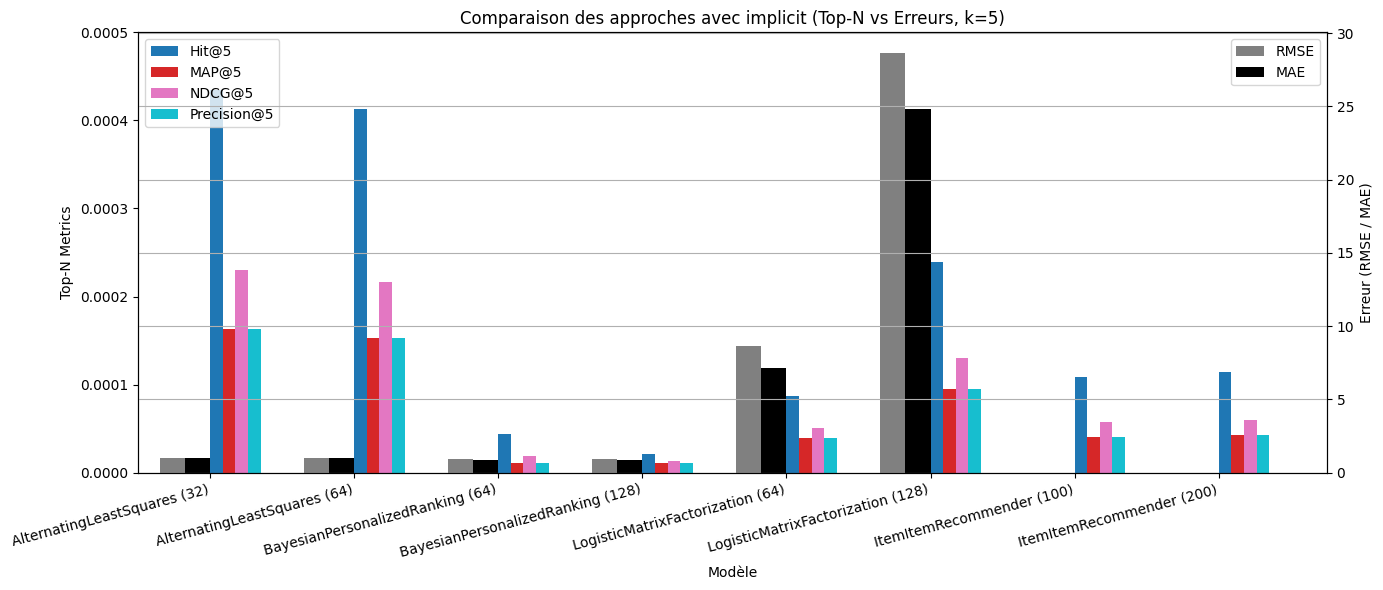

In [40]:
import matplotlib.pyplot as plt
import pandas as pd

# Convertir en DataFrame indexé par le nom du modèle + params simples
df_results = df_grid_results.copy()

# Préparer une colonne "paramètre principal" (factors ou K)
df_results["main_param"] = (
    df_results["param_factors"]
    .fillna(df_results["param_K"])
    .fillna("NA")
    .astype("Int64")
    .astype(str)
)

# Construire le nom de l’approche (ex : ALS (64), IIR (100))
df_results["Approche"] = df_results["Model"] + " (" + df_results["main_param"] + ")"
df_results.set_index("Approche", inplace=True)


# Liste des métriques
topn_metrics = ["Hit@5", "MAP@5", "NDCG@5", "Precision@5"]
error_metrics = ["RMSE", "MAE"]

# Création du graphique
fig, ax1 = plt.subplots(figsize=(14, 6))

# Barres des top-N metrics
df_results[topn_metrics].plot(kind='bar', ax=ax1, position=0, width=0.35, colormap='tab10')
ax1.set_ylabel("Top-N Metrics")
#ax1.set_ylim(0, 1.05)
# Échelle dynamique adaptée aux valeurs faibles
topn_max = df_results[topn_metrics].max().max()
ax1.set_ylim(0, max(0.0005, topn_max * 1.1))
ax1.set_xlabel("Modèle")
ax1.set_xticklabels(df_results.index, rotation=15, ha='right')
ax1.legend(loc='upper left')

# Barres des error metrics à droite
ax2 = ax1.twinx()
df_results[error_metrics].plot(kind='bar', ax=ax2, position=1, width=0.35, color=["gray", "black"])
ax2.set_ylabel("Erreur (RMSE / MAE)")
ax2.legend(loc='upper right')

# Ajustement de l'axe X
ax1.set_xlim(-0.5, len(df_results) - 0.25)

plt.title("Comparaison des approches avec implicit (Top-N vs Erreurs, k=5)")
plt.grid(True)
plt.tight_layout()
plt.show()
